In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import griddata
from scipy import signal

In [2]:
from IPython.core.display import HTML

# Center plots
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

Let's start by reading both data sets from today.

In [3]:
trial_info = pd.read_csv('trials.csv', index_col=0)
measurements = pd.read_csv('measurements.csv', index_col=0)

# Keep only some trials
trials = {2: measurements[measurements['trial_id'] == 2], 
          3: measurements[measurements['trial_id'] == 3]}

# Make a note of associated split shot data
trial_info['split_shot'] = [15, 15, 12]

Let's plot TDS vs. time for both data sets.

<ipython-input-4-a049872880b1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start'] = np.concatenate([np.array([df['start_time'].values[0]]), split_times])
<ipython-input-4-a049872880b1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['end'] = np.concatenate([split_times, np.array([df['end_time'].values[-1]])])
<ipython-input-4-a049872880b1>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

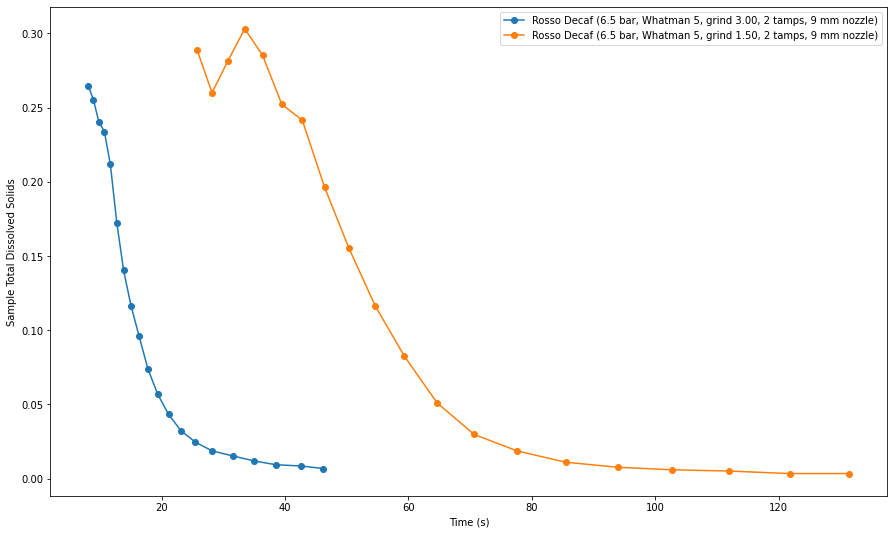

In [4]:
def adjust_times(df):
    # Calculate split times
    split_times = (df['end_time'].values[:-1] + df['start_time'].values[1:]) / 2.

    df['start'] = np.concatenate([np.array([df['start_time'].values[0]]), split_times])
    df['end'] = np.concatenate([split_times, np.array([df['end_time'].values[-1]])])

def get_sample_tds(df):
    # Calculate Brix from diluted measurements
    df['brix_from_dilution'] = (df['weight_after_dilution'] - df['weight_empty']) / (df['weight_before_dilution'] - df['weight_empty']) * df['diluted_brix']

    # Now convert to TDS
    df['tds'] = df['brix_percent'] * 0.85 / 100.
    df['tds_from_dilution'] = df['brix_from_dilution'] * 0.85 / 100.
    
    # Fill in missing data
    df['tds_filled'] = df['tds'].where(df['tds'].notna(), df['tds_from_dilution'])

for index, df in trials.items():
    adjust_times(df)
    get_sample_tds(df)

# Create the figure
fig, ax = plt.subplots(figsize=(15,9))

# Label the axes
ax.set_xlabel('Time (s)')
ax.set_ylabel('Sample Total Dissolved Solids')

# Plot TDS
for index, df in trials.items():
    ax.plot(df['end'], df['tds_filled'], marker = 'o', label=trial_info['description'][index])

# Add a legend to the plot
ax.legend()

Now let's calculate brew ratio, TDS, and EY.

<ipython-input-5-45b04cfeb932>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['liquid_weight'] = df['weight_full'] - df['weight_empty']
<ipython-input-5-45b04cfeb932>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['cumulative_weight'] = df['liquid_weight'].cumsum()
<ipython-input-5-45b04cfeb932>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

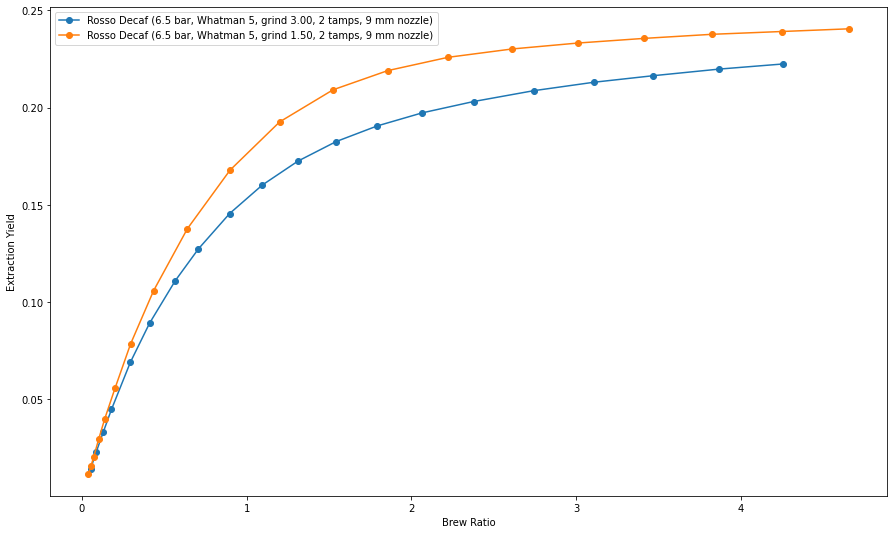

In [5]:
def get_br(df, weight_in):
    # Calculate beverage weight
    df['liquid_weight'] = df['weight_full'] - df['weight_empty']
    df['cumulative_weight'] = df['liquid_weight'].cumsum()
    
    # Calculate brew ratio
    df['br'] = df['cumulative_weight'] / weight_in

def get_tds(df):
    df['dissolved_weight'] = df['tds_filled'] * df['liquid_weight']
    df['cumulative_dissolved'] = df['dissolved_weight'].cumsum()
    df['tds'] = df['cumulative_dissolved'] / df['cumulative_weight']
    
def get_ey(df, weight_in):
    df['ey'] = df['cumulative_dissolved'] / weight_in

for index, df in trials.items():
    weight_in = trial_info['weight_in_basket'][index]
    get_br(df, weight_in)
    get_tds(df)
    get_ey(df, weight_in)

# Create the figure
fig, ax = plt.subplots(figsize=(15,9))

# Label the axes
ax.set_xlabel('Brew Ratio')
ax.set_ylabel('Extraction Yield')

# Plot EY
for index, df in trials.items():
    ax.plot(df['br'], df['ey'], marker = 'o', label=trial_info['description'][index])

# Add a legend to the plot
ax.legend()

Now let's compare this with the split shot data.

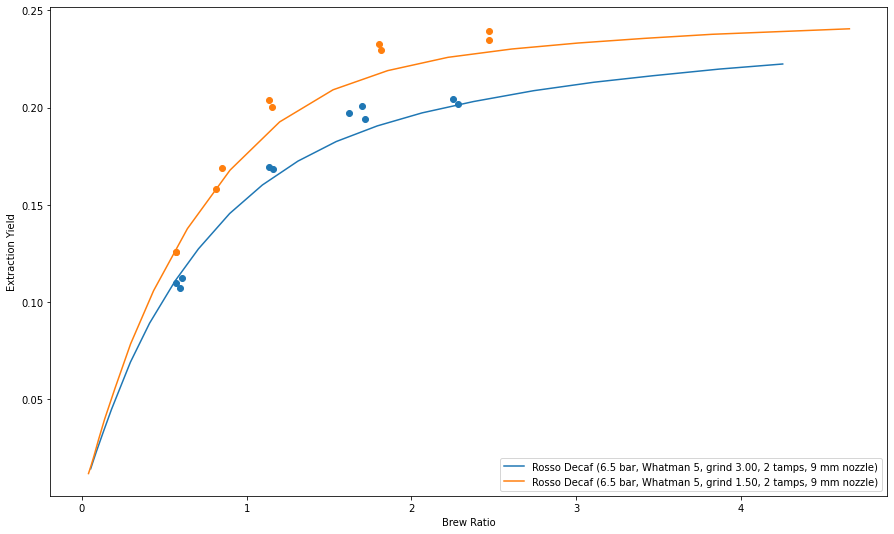

In [6]:
def get_split_shot(trial_id):
    # Read shot info from database
    shots = pd.read_excel('../../../database.xlsx', sheet_name='shots', header=0, index_col=0)

    # Keep only one trial
    shots = shots[shots['trial_id'] == trial_id]

    # Complete split data with full data
    shots['split_weight'] = shots['split_weight'].fillna(shots['weight_in_cup'])
    shots['split_brix'] = shots['split_brix'].fillna(shots['brix_percent'])

    # Ignore shots with no Brix measurement
    shots = shots.dropna(subset=['weight_in_basket', 'split_brix'])

    # Calculate TDS, EY, and brew ratio
    shots['tds'] = shots['split_brix'] / 100. * 0.85
    shots['ey'] = shots['tds'] * shots['split_weight'] / shots['weight_in_basket']
    shots['br'] = shots['split_weight'] / shots['weight_in_basket']
    
    return shots

# Create the figure
fig, ax = plt.subplots(figsize=(15,9))

# Label the axes
ax.set_xlabel('Brew Ratio')
ax.set_ylabel('Extraction Yield')

# Get split shot data
split_shots = {}
for index, df in trials.items():
    split_shots[index] = get_split_shot(trial_info['split_shot'][index])

for index, df in trials.items():
    # Plot Salamibot data
    ax.plot(df['br'], df['ey'], label=trial_info['description'][index])
    
    # Plot split shot data
    shots = split_shots[index]
    ax.scatter(shots['br'], shots['ey'])

# Add a legend to the plot
ax.legend()

To deconvolve the Salamibot data, we'll need to grid it.

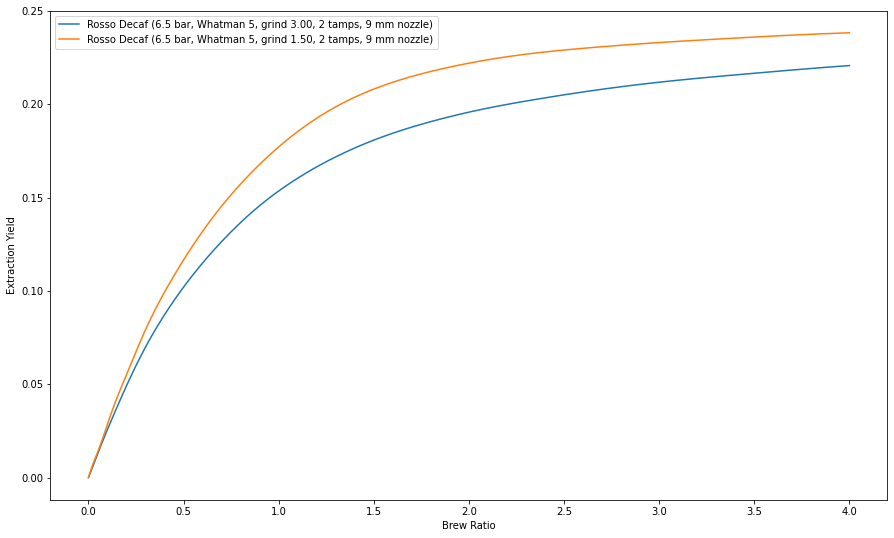

In [7]:
# Get grid points
xlim = (0., 4.)
n = round((xlim[1] - xlim[0]) / 0.01) + 1
xs = np.linspace(xlim[0], xlim[1], n)

# Create the figure
fig, ax = plt.subplots(figsize=(15,9))

# Label the axes
ax.set_xlabel('Brew Ratio')
ax.set_ylabel('Extraction Yield')

for index, df in trials.items():
    # Get gridded values
    ys = griddata(np.concatenate([[0], df['br'].values]), np.concatenate([[0], df['ey'].values]), xs, method='cubic')
    
    # Plot gridded data
    ax.plot(xs, ys, label=trial_info['description'][index])

# Add a legend to the plot
ax.legend()

Let's take a quick look at how convolution/deconvolution works in SciPy<sup>[1]</sup>.

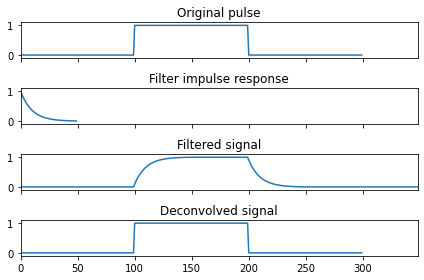

In [8]:
sig = np.repeat([0., 1., 0.], 100)
win = signal.windows.exponential(50, 0, 10, False)
filtered = signal.convolve(sig, win) / sum(win)
deconvolved, _ = signal.deconvolve(filtered * sum(win), win)

fig, (ax_orig, ax_win, ax_filt, ax_decon) = plt.subplots(4, 1, sharex=True)
ax_orig.plot(sig)
ax_orig.set_title('Original pulse')
ax_orig.margins(0, 0.1)
ax_win.plot(win)
ax_win.set_title('Filter impulse response')
ax_win.margins(0, 0.1)
ax_filt.plot(filtered)
ax_filt.set_title('Filtered signal')
ax_filt.margins(0, 0.1)
ax_decon.plot(deconvolved)
ax_decon.set_title('Deconvolved signal')
ax_decon.margins(0, 0.1)
fig.tight_layout()

Now let's try deconvolving our data.

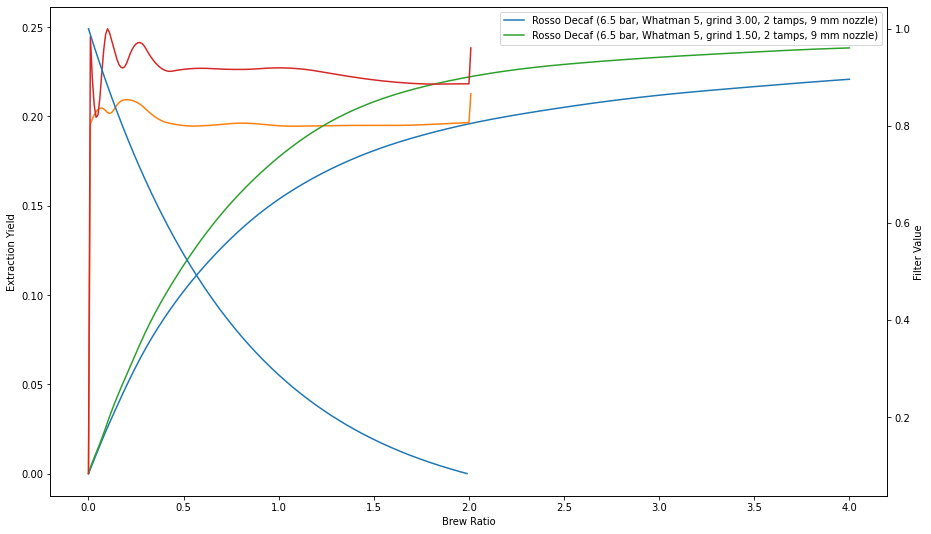

In [9]:
# Exponential function
win_len = 200
win = signal.windows.exponential(win_len, 0, 80, False)

# Create the figure
fig, ax1 = plt.subplots(figsize=(15,9))
ax2 = ax1.twinx()

# Label the axes
ax1.set_xlabel('Brew Ratio')
ax1.set_ylabel('Extraction Yield')
ax2.set_ylabel('Filter Value')

ax2.plot(xs[:win_len], win)

for index, df in trials.items():
    # Get gridded values
    ys = griddata(np.concatenate([[0], df['br'].values]), np.concatenate([[0], df['ey'].values]), xs, method='cubic')

    # Deconvolve
    res, _ = signal.deconvolve(ys * sum(win), win)
    
    # Plot gridded data
    ax1.plot(xs, ys, label=trial_info['description'][index])
    ax1.plot(xs[:-win_len+1], res)

# Add a legend to the plot
ax1.legend()

Ah, but we don't expect averaging to occur in the EY vs. brew ratio domain--we expect it to occur in sample TDS vs. brew ratio, or sample TDS vs. time. In that domain, the split shot data shows more extraction earlier, and less extraction later, sort of like this:

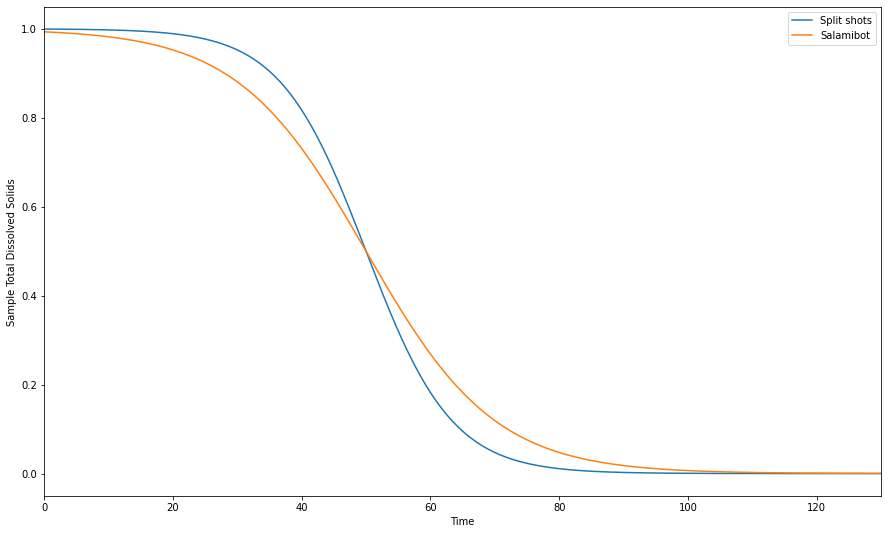

In [10]:
# Get functions
xs = np.linspace(-200., 200., 1000)
xss = (xs-50)/10
y1 = 1 - np.exp(xss) / (1 + np.exp(xss))
y2 = 1 - np.exp(xss * 1.5) / (1 + np.exp(xss * 1.5))

# Create the figure
fig, ax = plt.subplots(figsize=(15,9))

# Label the axes
ax.set_xlabel('Time')
ax.set_ylabel('Sample Total Dissolved Solids')

# Plot functions
ax.plot(xs, y2, label='Split shots')
ax.plot(xs, y1, label='Salamibot')

# Set plot range
ax.set_xlim([0., 130.])

# Add a legend to the plot
ax.legend()

What would it look like if we smoothed this model of the split shot data?

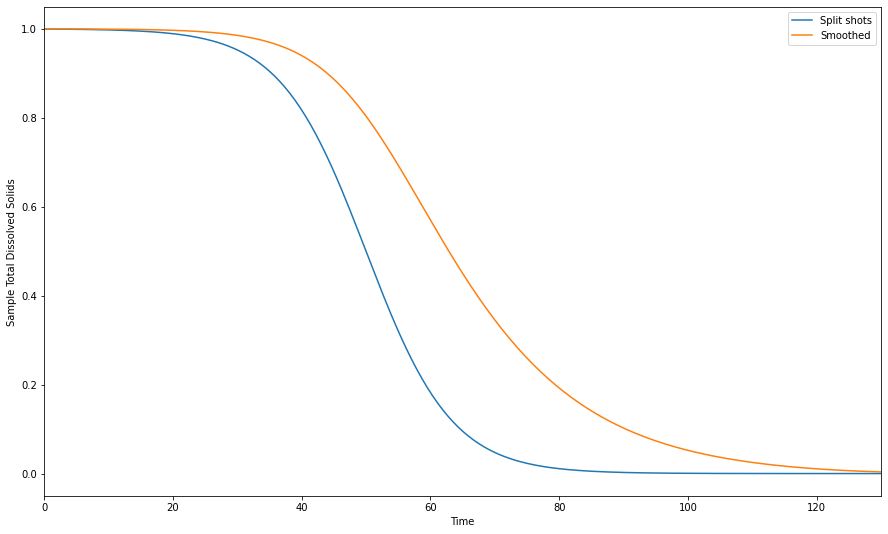

In [11]:
# Smooth the data
n_filt = 200
win = signal.windows.exponential(n_filt, 0, 40, False)
filtered = signal.convolve(y2, win)[:1000] / sum(win)

# Create the figure
fig, ax = plt.subplots(figsize=(15,9))

# Label the axes
ax.set_xlabel('Time')
ax.set_ylabel('Sample Total Dissolved Solids')

# Plot functions
ax.plot(xs, y2, label='Split shots')
ax.plot(xs, filtered, label='Smoothed')

# Set plot range
ax.set_xlim([0., 130.])

# Add a legend to the plot
ax.legend()

With a time shift, this could do it.

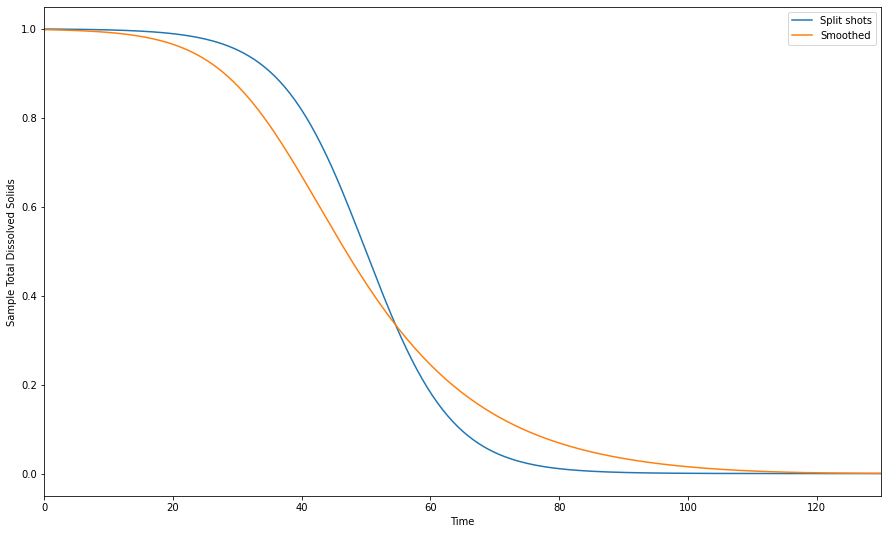

In [12]:
# Create the figure
fig, ax = plt.subplots(figsize=(15,9))

# Label the axes
ax.set_xlabel('Time')
ax.set_ylabel('Sample Total Dissolved Solids')

# Plot functions
ax.plot(xs, y2, label='Split shots')
ax.plot(xs - 40 / 1000 * 400, filtered, label='Smoothed')

# Set plot range
ax.set_xlim([0., 130.])

# Add a legend to the plot
ax.legend()

So, what if we deconvolve the Salamibot data at the sample TDS stage (either in terms of time or brew ratio), then work forward from there? Alternatively, it might be better to add smoothing to the model, then fit that as part of model fitting. This way, we aren't trying to deconvolve measurements with noise.

# References

[1] https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve.html